In [13]:
import pandas as pd
import torch
torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = True
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import tensorflow_hub as hub

import torch.nn as nn
from transformers import AutoModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import torch.optim as optim
import torch.nn.functional as F

import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split

import optuna

In [14]:
# train 70%, val 20%, test 10%
df = pd.read_csv("Research_Papers_Dataset_clean.csv")
df = df.dropna(subset=['title', 'abstract'])
df = df.head(10000)
df.reset_index(drop=True, inplace=True)

X_train, X_temp = train_test_split(df, test_size=0.3, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=1/3, random_state=42)
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (7000, 8), Validation: (2000, 8), Test: (1000, 8)


In [15]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/distiluse-base-multilingual-cased-v1")

class PaperDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        title = str(self.data.iloc[idx]["title"])
        abstract = str(self.data.iloc[idx]["abstract"])
        input_text = title + " " + abstract  # Combine title and abstract
        
        tokens = self.tokenizer(
            input_text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": tokens["input_ids"].squeeze(0),
            "attention_mask": tokens["attention_mask"].squeeze(0),
            "paper_index": idx  # Used for retrieval
        }

# Create dataset and DataLoader
dataset_train = PaperDataset(X_train, tokenizer, 256)
dataset_val = PaperDataset(X_val, tokenizer, 256)
dataloader = DataLoader(dataset_train, batch_size=8, shuffle=True)

In [16]:
for batch in dataloader:
    print("Batch Input IDs Shape:", batch["input_ids"].shape)
    print("Batch Attention Mask Shape:", batch["attention_mask"].shape)
    break  # Check only the first batch

Batch Input IDs Shape: torch.Size([8, 256])
Batch Attention Mask Shape: torch.Size([8, 256])


In [17]:
class PaperRecommender(nn.Module):
    def __init__(self, model_name, embedding_dim, num_heads, dropout):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.embedding_dim = embedding_dim  # Ensure this is correctly set

        # Ensure projection layer matches `embedding_dim`
        self.fc = nn.Linear(self.encoder.config.hidden_size, embedding_dim)  
        
        # Multiheaded attention layer using the correct `embedding_dim`
        self.attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=dropout)

        self.dropout = nn.Dropout(dropout)
        self.normalize = nn.functional.normalize

    def forward(self, input_ids, attention_mask):
        input_ids = input_ids.to(next(self.parameters()).device)
        attention_mask = attention_mask.to(next(self.parameters()).device)

        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token representation

        embedding = self.fc(self.dropout(pooled_output))  # Apply projection
        embedding = embedding.unsqueeze(0)  # Reshape for MultiheadAttention

        # Multiheaded Attention
        attn_output, _ = self.attention(embedding, embedding, embedding)
        attn_output = attn_output.squeeze(0)  # Remove batch dim

        return self.normalize(attn_output, p=2, dim=1)  # Normalize embeddings

In [18]:
def compute_tfidf_similarity(df):
    corpus = df['title'] + " " + df['abstract']
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(corpus)
    similarity_matrix = cosine_similarity(tfidf_matrix)
    return similarity_matrix

similarity_matrix_np = compute_tfidf_similarity(df)
# Convert to tensor for GPU computation
similarity_matrix = torch.tensor(similarity_matrix_np, dtype=torch.float32).to("cuda")
print(similarity_matrix)

threshold = 0.0785

positive_pairs = similarity_matrix > threshold
negative_pairs = ~positive_pairs
print(positive_pairs)
print(negative_pairs)

tensor([[1.0000, 0.0457, 0.0180,  ..., 0.0278, 0.0782, 0.0898],
        [0.0457, 1.0000, 0.0227,  ..., 0.0343, 0.0432, 0.0933],
        [0.0180, 0.0227, 1.0000,  ..., 0.0205, 0.0161, 0.0346],
        ...,
        [0.0278, 0.0343, 0.0205,  ..., 1.0000, 0.0207, 0.0474],
        [0.0782, 0.0432, 0.0161,  ..., 0.0207, 1.0000, 0.0760],
        [0.0898, 0.0933, 0.0346,  ..., 0.0474, 0.0760, 1.0000]],
       device='cuda:0')
tensor([[ True, False, False,  ..., False, False,  True],
        [False,  True, False,  ..., False, False,  True],
        [False, False,  True,  ..., False, False, False],
        ...,
        [False, False, False,  ...,  True, False, False],
        [False, False, False,  ..., False,  True, False],
        [ True,  True, False,  ..., False, False,  True]], device='cuda:0')
tensor([[False,  True,  True,  ...,  True,  True, False],
        [ True, False,  True,  ...,  True,  True, False],
        [ True,  True, False,  ...,  True,  True,  True],
        ...,
        [ Tr

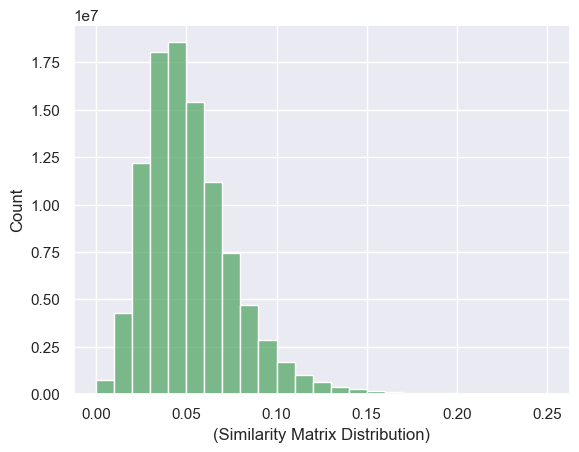

85th percentile: 0.0756
90th percentile: 0.0839
95th percentile: 0.0980


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#Organize Data
similarity_values_np = similarity_matrix_np.flatten()
similarity_values_np_filtered = similarity_values_np[similarity_values_np <= 0.25]
X = pd.Series(similarity_values_np_filtered, name="(Similarity Matrix Distribution)")

#Plot Data
fig, ax = plt.subplots()
sns.histplot(X, bins=25, color="g", ax=ax)
plt.show()

# Compute percentiles
percentiles = [85, 90, 95]
percentile_values = np.percentile(similarity_values_np_filtered, percentiles)

# Print results
for p, val in zip(percentiles, percentile_values):
    print(f"{p}th percentile: {val:.4f}")

In [20]:
def save_model(model, optimizer, epoch, loss, path="./paper_recommender_Large.pth"):
    """Save the model, optimizer state, and training metadata."""
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss
    }
    torch.save(checkpoint, path)
    print(f"Model saved at {path}")

In [21]:
def load_model(model, optimizer=None, path = "./paper_recommender_Large.pth"):
    """Load the model and optionally the optimizer."""
    checkpoint = torch.load(path, map_location="cuda" if torch.cuda.is_available() else "cpu")
    
    model.load_state_dict(checkpoint["model_state_dict"])
    print(f"Model loaded from {path}, trained until epoch {checkpoint['epoch']}")
    
    if optimizer:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        print("Optimizer state restored.")

    return checkpoint["epoch"], checkpoint["loss"]

In [22]:
def contrastive_loss(embeddings, similarity_matrix, indices, margin=0.5):
    """
    Contrastive loss using TF-IDF similarity as ground truth.
    
    embeddings: (batch_size, embedding_dim)
    similarity_matrix: Precomputed TF-IDF cosine similarity.
    indices: Indices of batch samples in dataset.
    margin: Margin for contrastive loss.
    """
    batch_size = embeddings.shape[0]

    # Ensure embeddings are L2 normalized
    embeddings = F.normalize(embeddings, p=2, dim=1)

    # Compute cosine similarity
    cosine_sim = torch.mm(embeddings, embeddings.T)  # (batch_size, batch_size)
    cosine_distances = 1 - cosine_sim  # Convert similarity to distance

    # Extract ground truth similarity values for batch samples
    ground_truth_similarities = similarity_matrix[indices][:, indices]

    # Define positive and negative pairs
    threshold = 0.1205  # Adjust this value if needed
    positive_pairs = (ground_truth_similarities > threshold).float()
    negative_pairs = (ground_truth_similarities <= threshold).float()

    # Compute losses
    positive_loss = (cosine_distances * positive_pairs).sum() / (positive_pairs.sum() + 1e-8)
    negative_loss = torch.clamp(margin - cosine_distances, min=0) * negative_pairs
    negative_loss = negative_loss.sum() / (negative_pairs.sum() + 1e-8)

    loss = positive_loss + negative_loss

    return loss


In [23]:
def objective(trial):
    # Define hyperparameter search space
    embedding_dim = trial.suggest_categorical("embedding_dim", [256, 512, 768])
    num_heads = trial.suggest_categorical("num_heads", [2,4,8,16])
    dropout = trial.suggest_float("dropout", 0.1, 0.3)

    # Initialize model with selected hyperparameters
    model = PaperRecommender("sentence-transformers/distiluse-base-multilingual-cased-v1",
                             embedding_dim, num_heads, dropout).to("cuda")
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    # Create train and validation dataloaders
    dataloader_train = DataLoader(dataset_train, batch_size=8, shuffle=True)
    dataloader_val = DataLoader(dataset_val, batch_size=8, shuffle=False)

    num_epochs = 3  # Use fewer epochs for tuning
    total_loss = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for batch in dataloader_train:
            input_ids = batch["input_ids"].to("cuda")
            attention_mask = batch["attention_mask"].to("cuda")
            indices = batch["paper_index"].cpu().numpy()

            optimizer.zero_grad()
            embeddings = model(input_ids, attention_mask)

            loss = contrastive_loss(embeddings, similarity_matrix, indices, margin=0.5)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(dataloader_train)

        # Validation step (compute loss on validation set)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in dataloader_val:
                input_ids = batch["input_ids"].to("cuda")
                attention_mask = batch["attention_mask"].to("cuda")
                indices = batch["paper_index"].cpu().numpy()

                embeddings = model(input_ids, attention_mask)
                val_loss += contrastive_loss(embeddings, similarity_matrix, indices, margin=0.5).item()

        avg_val_loss = val_loss / len(dataloader_val)
        total_loss += avg_val_loss

    return total_loss / num_epochs  # Minimize validation loss

In [24]:
study = optuna.create_study(direction="minimize")  # We want to minimize loss
study.optimize(objective, n_trials=20)  # Run 20 trials

print("Best hyperparameters:", study.best_params)

[I 2025-03-16 12:55:20,959] A new study created in memory with name: no-name-fc3f627a-ca05-4116-97a3-71ba41f3ec96
[I 2025-03-16 13:21:38,183] Trial 0 finished with value: 0.07100067871809006 and parameters: {'embedding_dim': 768, 'num_heads': 2, 'dropout': 0.17640719951859918}. Best is trial 0 with value: 0.07100067871809006.
[I 2025-03-16 13:46:51,205] Trial 1 finished with value: 0.08115892608650029 and parameters: {'embedding_dim': 512, 'num_heads': 8, 'dropout': 0.1464813236867561}. Best is trial 0 with value: 0.07100067871809006.
[I 2025-03-16 14:12:07,728] Trial 2 finished with value: 0.062067316538887106 and parameters: {'embedding_dim': 768, 'num_heads': 2, 'dropout': 0.10617760648864663}. Best is trial 2 with value: 0.062067316538887106.
[I 2025-03-16 14:37:24,300] Trial 3 finished with value: 0.09676277039945126 and parameters: {'embedding_dim': 768, 'num_heads': 4, 'dropout': 0.21207132702581954}. Best is trial 2 with value: 0.062067316538887106.
[I 2025-03-16 15:02:36,747] 

Best hyperparameters: {'embedding_dim': 256, 'num_heads': 2, 'dropout': 0.10103513964785935}


In [25]:
# Initialize model
model = PaperRecommender("sentence-transformers/distiluse-base-multilingual-cased-v1",
                               study.best_params["embedding_dim"],
                               study.best_params["num_heads"],
                               study.best_params["dropout"]).to("cuda")

optimizer = optim.Adam(model.parameters(), lr=1e-5)

num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0

    for batch in dataloader:
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")
        indices = batch["paper_index"].cpu().numpy()

        optimizer.zero_grad()
        embeddings = model(input_ids, attention_mask)

        loss = contrastive_loss(embeddings, similarity_matrix, indices, margin=0.5)

        if loss.item() == 0:
            print(f"Warning: Zero loss at epoch {epoch+1}. Debug required.")
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}")
    save_model(model, optimizer, epoch + 1, avg_loss, "paper_recommender_Large.pth")


Epoch 1, Avg Loss: 0.0673
Model saved at paper_recommender_Large.pth
Epoch 2, Avg Loss: 0.0624
Model saved at paper_recommender_Large.pth
Epoch 3, Avg Loss: 0.0668
Model saved at paper_recommender_Large.pth
Epoch 4, Avg Loss: 0.0620
Model saved at paper_recommender_Large.pth
Epoch 5, Avg Loss: 0.0587
Model saved at paper_recommender_Large.pth
Epoch 6, Avg Loss: 0.0597
Model saved at paper_recommender_Large.pth
Epoch 7, Avg Loss: 0.0611
Model saved at paper_recommender_Large.pth
Epoch 8, Avg Loss: 0.0624
Model saved at paper_recommender_Large.pth
Epoch 9, Avg Loss: 0.0586
Model saved at paper_recommender_Large.pth
Epoch 10, Avg Loss: 0.0610
Model saved at paper_recommender_Large.pth


In [26]:
# Initialize model
model = PaperRecommender("sentence-transformers/distiluse-base-multilingual-cased-v1",
                               256,
                               2,
                               0.15).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Load the model (after training)
epoch, loss = load_model(model, optimizer, "paper_recommender_Large.pth")
model.eval()  # Set to evaluation mode

Model loaded from paper_recommender_Large.pth, trained until epoch 10
Optimizer state restored.


PaperRecommender(
  (encoder): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

In [27]:
def recommend_papers(query, model, df, top_k=5):
    model.eval()
    
    # Tokenize and encode query
    query_tokens = tokenizer(query, padding="max_length", truncation=True, max_length=512, return_tensors="pt").to("cuda")
    
    with torch.no_grad():
        query_embedding = model(query_tokens["input_ids"], query_tokens["attention_mask"]).cpu().numpy()

    # Compute Euclidean distances between query and all paper embeddings
    paper_embeddings = []
    paper_indices = []

    for batch in dataloader:
        batch_input_ids = batch["input_ids"].to("cuda")
        batch_attention_mask = batch["attention_mask"].to("cuda")

        with torch.no_grad():
            batch_embeddings = model(batch_input_ids, batch_attention_mask).cpu().numpy()
            paper_embeddings.append(batch_embeddings)
            paper_indices.extend(batch["paper_index"].numpy())  # Store original indices

    paper_embeddings = np.vstack(paper_embeddings)  # Stack all embeddings
    paper_indices = np.array(paper_indices)

    # Compute pairwise Euclidean distances
    distances = np.linalg.norm(paper_embeddings - query_embedding, axis=1)

    # Get top-k closest papers (smallest distances)
    top_indices = np.argsort(distances)[:top_k]

    print("\nRecommended Papers:")
    for idx in top_indices:
        paper_idx = paper_indices[idx]
        print(f"Title: {df.iloc[paper_idx]['title']}\nAbstract: {df.iloc[paper_idx]['abstract']}\nDistance: {distances[idx]:.4f}\n")

In [28]:
recommend_papers("deep learning for edge computing", model, df)


Recommended Papers:
Title: Design space abstraction and metamodeling for embedded systems design space exploration
Abstract: In this paper, we present a design space exploration (DSE) method for embedded systems, which represents the design space as a categorical graph product, in order to overcome the challenge of performing multiple DSE activities, such as task mapping, processor allocation, and software binding. Moreover, the method adopts a Model-Driven Engineering (MDE) approach, defining a design space metamodel to represent the categorical graph product and other DSE concepts, such as solutions, costs, and DSE activities. Furthermore, exploiting the MDE approach, we use model-to-model transformation rules to implement the design constraints, which guide and prune the design space. The method is applied to the design of a real-life application, and experiments demonstrate its effectiveness.
Distance: 0.7357

Title: Data sharing in mobile ad-hoc networks - a study of replication 

In [29]:
# Generate embeddings for all papers using the trained model
def get_embeddings(dataloader, model):
    model.eval()
    embeddings = []
    paper_indices = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to("cuda")
            attention_mask = batch["attention_mask"].to("cuda")

            batch_embeddings = model(input_ids, attention_mask)  # Keep as CUDA tensor
            embeddings.append(batch_embeddings)  # Store without converting to NumPy
            paper_indices.extend(batch["paper_index"].numpy())

    return torch.cat(embeddings, dim=0), np.array(paper_indices)  # Return PyTorch tensor

# Get embeddings for train and test sets
train_dataloader = DataLoader(PaperDataset(X_train, tokenizer, 256), batch_size=8, shuffle=False)
test_dataloader = DataLoader(PaperDataset(X_test, tokenizer, 256), batch_size=8, shuffle=False)

train_embeddings, train_indices = get_embeddings(train_dataloader, model)
test_embeddings, test_indices = get_embeddings(test_dataloader, model)

# Compute cosine similarity in CUDA
train_embeddings = F.normalize(train_embeddings, p=2, dim=1)  # Normalize embeddings
test_embeddings = F.normalize(test_embeddings, p=2, dim=1)

print("Sample Test Embedding:", test_embeddings[0][:15])  # First 15 values
print("Sample Train Embedding:", train_embeddings[0][:15])  # First 15 values

similarity_matrix = torch.matmul(test_embeddings, train_embeddings.T).cpu().numpy()  # Cosine similarity

# Select top-N most similar papers
top_n = 10
top_indices = np.argsort(-similarity_matrix, axis=1)[:, :top_n]

# Print recommended papers
recommended_paper_ids = []

for i, test_idx in enumerate(top_indices):
    recommended_for_test = []
    print(f"\nTest Paper {i+1}:")
    
    for j, train_idx in enumerate(test_idx[1:15]):
        recommended_paper_id = X_train.iloc[train_indices[train_idx]]["Id"]
        recommended_for_test.append(recommended_paper_id)
        
        print(f"  {j+1}. Recommended Paper ID: {recommended_paper_id} (Similarity: {similarity_matrix[i, train_idx]:.4f})")
    
    recommended_paper_ids.append(recommended_for_test)

Sample Test Embedding: tensor([-0.0076, -0.0083,  0.0192,  0.0463,  0.0204, -0.0167,  0.0394,  0.0891,
         0.0583, -0.0393, -0.1276,  0.0174, -0.0865, -0.0312, -0.0016],
       device='cuda:0')
Sample Train Embedding: tensor([ 0.0408,  0.0692,  0.0076,  0.0218,  0.0314, -0.0222,  0.0052,  0.0636,
         0.0642,  0.0314, -0.0972,  0.0009, -0.0870,  0.0390, -0.0090],
       device='cuda:0')

Test Paper 1:


KeyError: 'Id'